## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Mi primera Red Neuronal Bayesiana

Las redes neuronales son modelos del estado del arte para hacer regresión y clasificación con datos complejos

Generalmente estos modelos requieren de una gran cantidad de datos para poder entrenarlos de forma efectiva y sin que se sobreajusten. Sin embargo, en algunos problemas los datos disponibles son simplemente muy escasos o muy difíciles de obtener. Adicionalmente, no es directo tomar decisiones en base al modelo, y se requiere un paso adicional de calibración. ¿Cómo podemos confiar en las decisiones del modelo?

Podemos intentar solucionar estos problemas escribiendo la red neuronal como un modelo bayesiano y aprender el posterior de sus parámetros con un método de Markov Chain Monte Carlo (siempre y cuando el modelo sea simple). 

Incorporando priors el modelo estará regularizado y en lugar de estimadores puntuales tendremos la distribución a posteriori completa. Esta rica información extra nos permite medir la confianza del modelo sobre sus predicciones (el modelo sabe cuando no sabe) facilitando la tarea de calibración. 



## Formulación clásica

En esta tarea se pide que programen un modelo de red neuronal para clasificación de datos bidimensionales, de dos clases, con una capa oculta y con función de activación sigmoidal

Sea el conjunto de datos y etiquetas

$$
\mathcal{D} = \{(x, y)^{(i)}, i=1,2,\ldots,N\} \quad x^{(i)} \in \mathbb{R}^2,  y^{(i)} \in \{0, 1\}
$$

Consideremos ahora una tupla en particular $(X, Y)$. La salida de la capa oculta en notación matricial es

$$
Z = \text{sigmoide}( W_Z X + B_Z)
$$

donde $W_Z \in \mathbb{R}^{M \times 2}$, $B_Z \in \mathbb{R}^{M}$ y  $M$ es el tamaño de la capa oculta

La salida de la capa visible (última capa) en notación matricial es

$$
Y = \text{sigmoide}( W_Y Z + B_Y)
$$

donde $W_Y \in \mathbb{R}^{1 \times M}$, $B_Z \in \mathbb{R}$

La función sigmoide se define como

$$
\text{sigmoide}(x) = \frac{1}{1+ e^{-x}}
$$

Luego $Z$ es un vector de largo $M$ con valores en $[0, 1]$ e $Y$ es un escalar con valor en el rango $[0, 1]$

## Formulación bayesiana

Para darle un toque bayesiano a este modelo debemos

- Definir priors para $W_Z$, $B_Z$, $W_Y$ y $B_Y$. Se pide que utilice priors **normales con media cero y desviación estándar diez**.
- Definir una verosimilitud para le problema. Dado que el problema es de clasificación binaria, utilice una distribución de **Bernoulli** con $p=Y$
- Considere los datos $X$ como una variable determínista. 

## Indicaciones

Utilice

- El atributo `shape` para darle la dimensión correcta a cada variable cada uno
- El atributo `observed` para asignar las etiquetas reales a esta variable aleatoria observada
- `pm.Data` para la variable independiente
- `theano.tensor.sigmoid` para calcular la función sigmoide
- `A.dot(B)` para calcular el producto matricial entre `A` y `B`



## Instrucciones específicas

- Considere el dataset sintético `two-moons` que se muestra a continuación. Se pide que realice dos experimentos variando el valor de `n_samples`, primero a $100$ y finalmente a $10$
- Implemente el modelo de red neuronal bayesiana en `pymc3` dejando $M$ como un argumento. Para cada valor de `n_samples` entrene tres modelos con $M=1$, $M=3$ y $M=10$
- Seleccione y calibre un algoritmo de MCMC para entrenar este modelo. Justifique y respalde sus decisiones en base al comportamiento de las trazas, al estadístico Gelman-Rubin y a la función de autocorrelación
- Estudie el posterior de los parámetros y evalue el posterior predictivo sobre los datos de prueba. Muestre graficamente la media y la varianza del posterior predictivo en el espacio de los datos. Haga observaciones y comparaciones entre los 6 casos (3 valores de $M$ y 2 valores de `n_samples`)

# Solucion

In [1]:
import pymc3 as pm
import theano
from theano.tensor.nnet import sigmoid

## Implementacion del modelo (n_samples = 100)

<IPython.core.display.Javascript object>


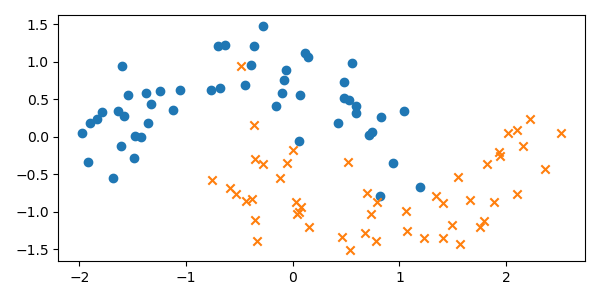

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test = np.vstack([x1.ravel(), x2.ravel()]).T

In [3]:
def modelrnb(M):
    with pm.Model() as bayes_reg:
        #datos de entrada
        X_shared = pm.Data("x", x).T
        Y_shared = pm.Data("y", y)
        #prioris
        wz = pm.Normal(name='wz', mu=0, sd =10, shape=(M,2))
        bz = pm.Normal(name='bz', mu=0, sd =10, shape=(M,1))
        wy = pm.Normal(name='wy', mu=0, sd =10, shape=(1,M))
        by = pm.Normal(name='by', mu=0, sd =10, shape=(1,1))
        #variable determinista 
        X = pm.Deterministic('X', X_shared)  
        #verosimilitud
        Z = sigmoid(wz.dot(X)+bz)
        Y = sigmoid(wy.dot(Z)+by)
        Y_obs = pm.Bernoulli('Y_obs', p=Y, observed=y)
    return bayes_reg

### Modelo 1 (M = 1)

In [93]:
a100 = modelrnb(1)
a100

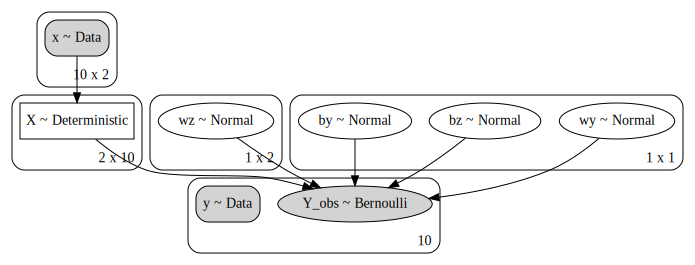

In [89]:
pm.model_to_graphviz(a100)

### Modelo 2 (M = 3)

In [83]:
b100 = modelrnb(3)
b100

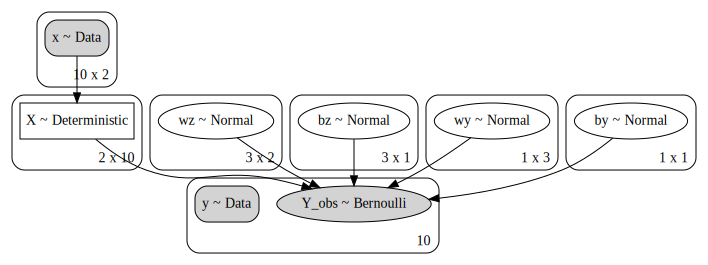

In [84]:
pm.model_to_graphviz(b100)

### Modelo 3 (M = 10)

In [85]:
c100 = modelrnb(10)
c100

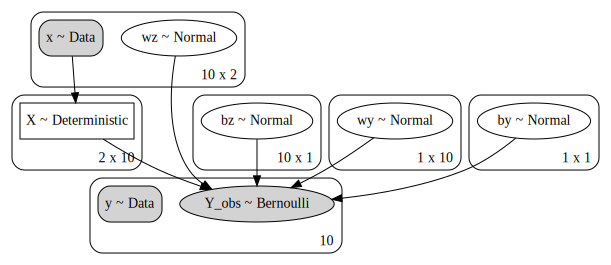

In [86]:
pm.model_to_graphviz(c100)

## Implementacion del modelo (n_samples = 10)

<IPython.core.display.Javascript object>


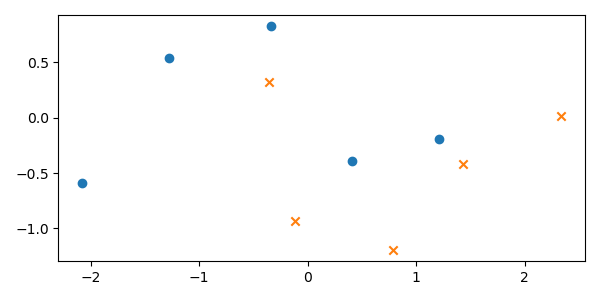

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=10, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test = np.vstack([x1.ravel(), x2.ravel()]).T

### Modelo 1 (M = 1)

In [11]:
a10 = modelrnb(1)
a10

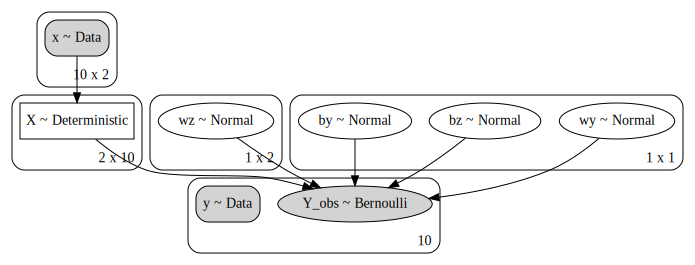

In [12]:
pm.model_to_graphviz(a10)

### Modelo 2 (M = 3)

In [13]:
b10 = modelrnb(3)
b10

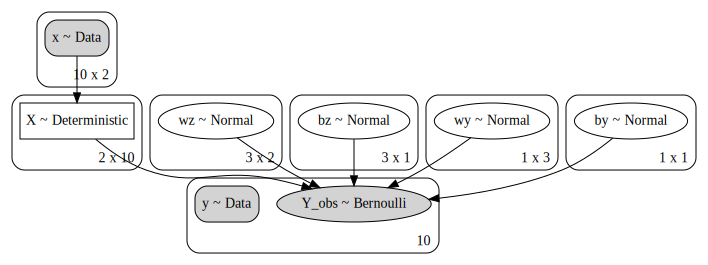

In [14]:
pm.model_to_graphviz(b10)

### Modelo 3 (M = 10)

In [15]:
c10 = modelrnb(10)
c10

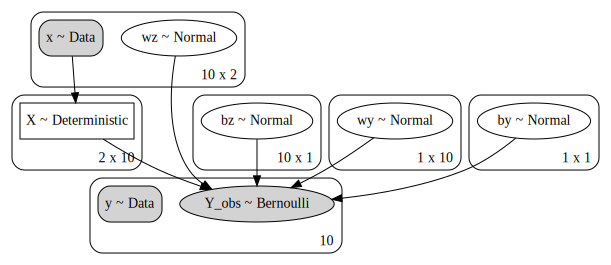

In [16]:
pm.model_to_graphviz(c10)

## Seleccion y calibracion de un algoritmo de MCMC para entrenar este modelo.

### Modelo 1 (100 samples)

#### Entrenamiento Algoritmo MCMC

In [94]:
with a100:
    trace = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 7000/7000 [01:05<00:00, 107.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


####  Trazas

<IPython.core.display.Javascript object>


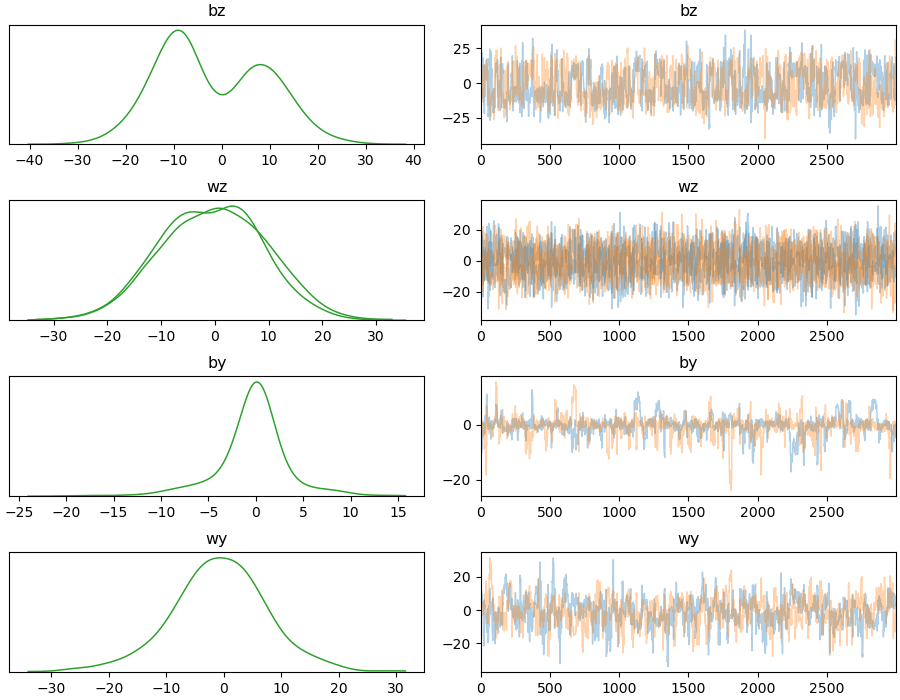

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [95]:
pm.traceplot(trace, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de r gorro

In [96]:
pm.summary(trace, var_names=['bz', 'wz', 'by','wy']).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"bz[0,0]",-1.856,11.332,-20.215,18.392,0.489,0.346,538.0,538.0,593.0,2101.0,1.0
"wz[0,0]",-0.976,9.313,-17.942,16.297,0.398,0.282,548.0,548.0,562.0,1991.0,1.0
"wz[0,1]",0.071,9.793,-17.395,18.545,0.393,0.278,620.0,620.0,627.0,1703.0,1.0
"by[0,0]",-0.329,3.695,-8.518,7.322,0.213,0.151,301.0,301.0,339.0,282.0,1.0
"wy[0,0]",-0.742,8.417,-16.403,16.500,0.440,0.311,367.0,367.0,355.0,584.0,1.0


#### autocorrelacion

<IPython.core.display.Javascript object>


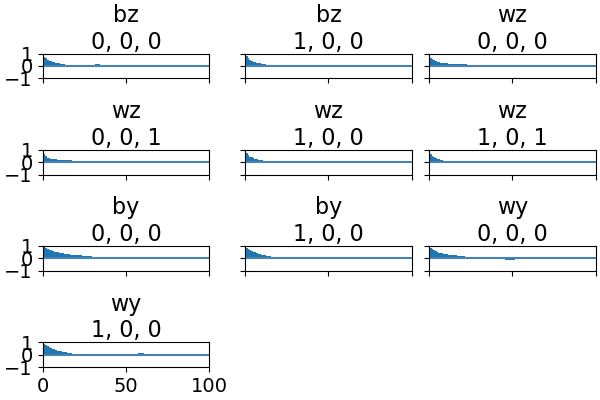

In [97]:
pm.plots.autocorrplot(trace, figsize=(6, 4), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 2 (100 samples)

####  Entrenamineto Algoritmo MCMC

In [98]:
with b100:
    trace = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 7000/7000 [02:31<00:00, 46.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


#### Trazas

<IPython.core.display.Javascript object>


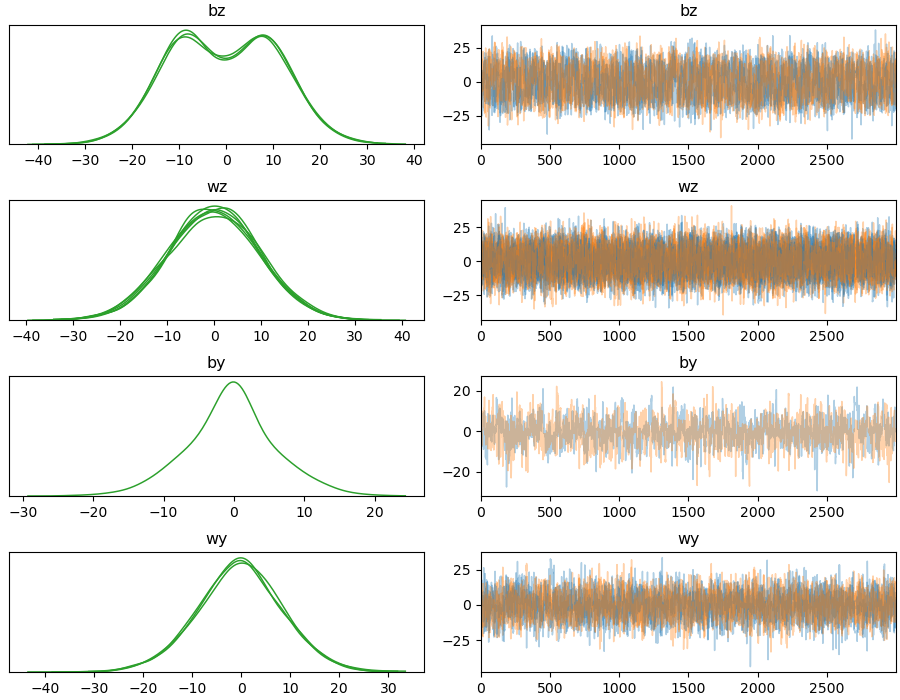

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [99]:
pm.traceplot(trace, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de r gorro

In [100]:
pm.summary(trace, var_names=['bz', 'wz', 'by','wy']).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"bz[0,0]",-0.207,11.243,-19.102,20.319,0.354,0.250,1010.0,1010.0,1098.0,3063.0,1.0
"bz[1,0]",-0.557,11.325,-20.301,19.234,0.350,0.248,1047.0,1047.0,1123.0,2995.0,1.0
"bz[2,0]",-0.362,11.157,-19.376,19.542,0.369,0.261,917.0,917.0,975.0,2625.0,1.0
"wz[0,0]",0.030,9.409,-17.563,17.748,0.257,0.182,1339.0,1339.0,1318.0,2184.0,1.0
"wz[0,1]",0.026,9.571,-17.792,18.062,0.231,0.164,1711.0,1711.0,1713.0,3125.0,1.0
"wz[1,0]",0.183,9.416,-17.946,17.597,0.247,0.175,1456.0,1456.0,1456.0,3121.0,1.0
"wz[1,1]",-0.416,9.702,-18.196,18.260,0.225,0.159,1853.0,1853.0,1852.0,3127.0,1.0
"wz[2,0]",-0.042,9.482,-17.668,17.542,0.261,0.185,1317.0,1317.0,1317.0,2504.0,1.0
"wz[2,1]",0.153,9.995,-19.513,17.776,0.231,0.163,1879.0,1879.0,1885.0,2665.0,1.0
"by[0,0]",-0.373,6.340,-12.810,11.877,0.192,0.136,1086.0,1086.0,1080.0,1181.0,1.0


#### autocorrelacion

<IPython.core.display.Javascript object>


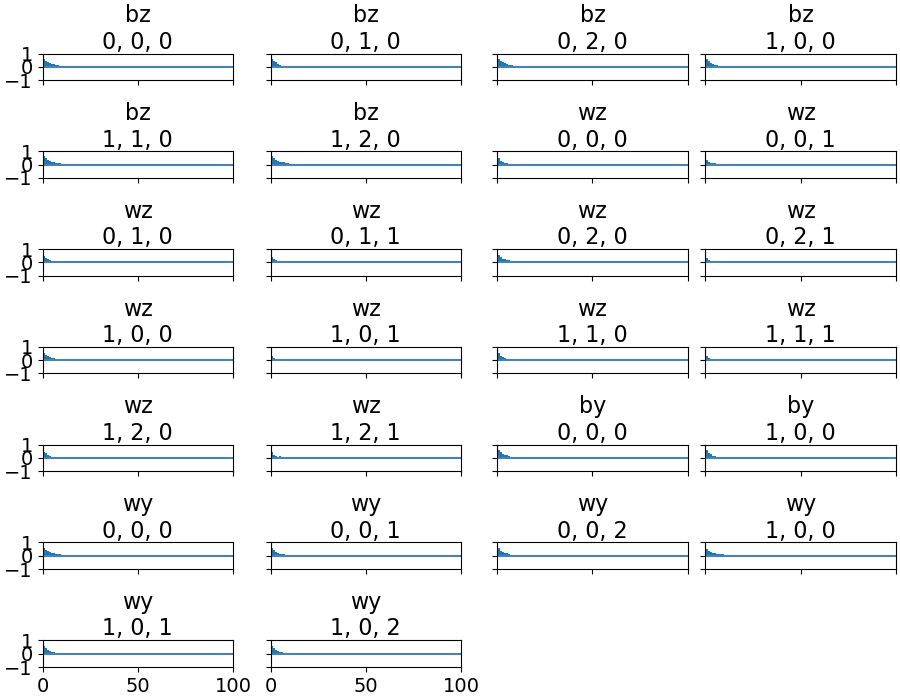

In [102]:
pm.plots.autocorrplot(trace, figsize=(9, 7), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 3 (100 samples)

In [103]:
with c100:
    trace = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 7000/7000 [03:38<00:00, 32.08draws/s]


#### Trazas 

<IPython.core.display.Javascript object>


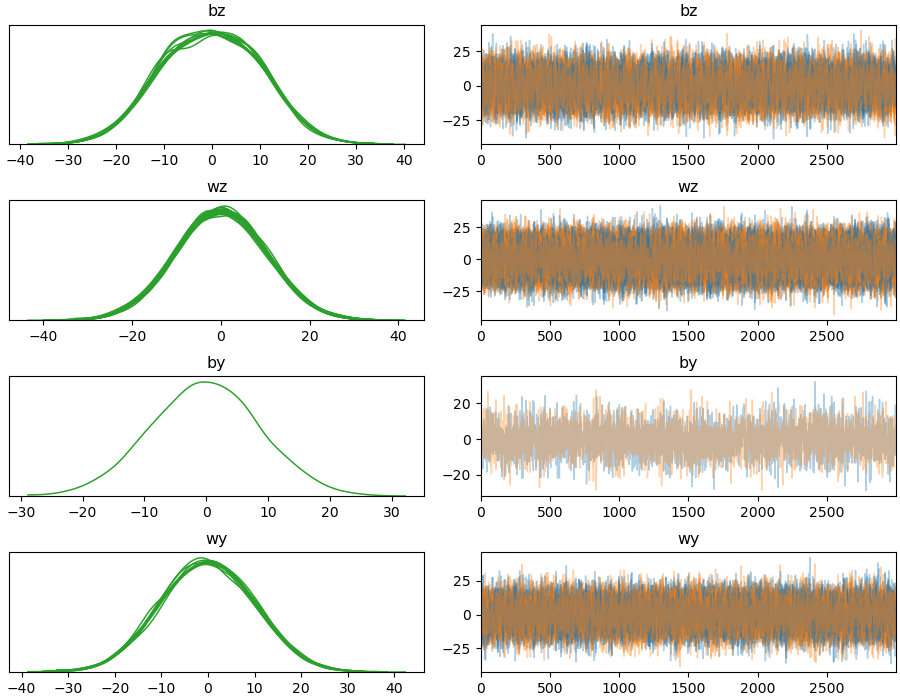

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


In [104]:
pm.traceplot(trace, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de r gorro

In [105]:
pm.summary(trace, var_names=['bz', 'wz', 'by','wy']).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"bz[0,0]",-0.211,10.376,-18.536,18.951,0.237,0.167,1921.0,1921.0,1968.0,3851.0,1.0
"bz[1,0]",0.089,10.238,-17.915,19.474,0.243,0.172,1777.0,1777.0,1804.0,3795.0,1.0
"bz[2,0]",0.254,10.358,-19.244,18.785,0.252,0.178,1686.0,1686.0,1712.0,3422.0,1.0
"bz[3,0]",-0.298,10.348,-19.833,17.561,0.232,0.164,1987.0,1987.0,2034.0,4065.0,1.0
"bz[4,0]",-0.185,10.273,-18.035,19.151,0.227,0.161,2048.0,2048.0,2102.0,3957.0,1.0
"bz[5,0]",-0.288,10.337,-19.145,19.058,0.246,0.174,1767.0,1767.0,1792.0,3552.0,1.0
"bz[6,0]",-0.363,10.198,-18.498,18.645,0.245,0.173,1731.0,1731.0,1766.0,3828.0,1.0
"bz[7,0]",-0.132,10.201,-18.934,18.244,0.235,0.167,1877.0,1877.0,1907.0,3368.0,1.0
"bz[8,0]",-0.250,10.578,-20.973,17.927,0.234,0.165,2047.0,2047.0,2084.0,4239.0,1.0
"bz[9,0]",-0.430,10.078,-18.725,17.618,0.216,0.153,2175.0,2175.0,2223.0,3907.0,1.0


#### autocorrelacion 

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (82) in plot_autocorr, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


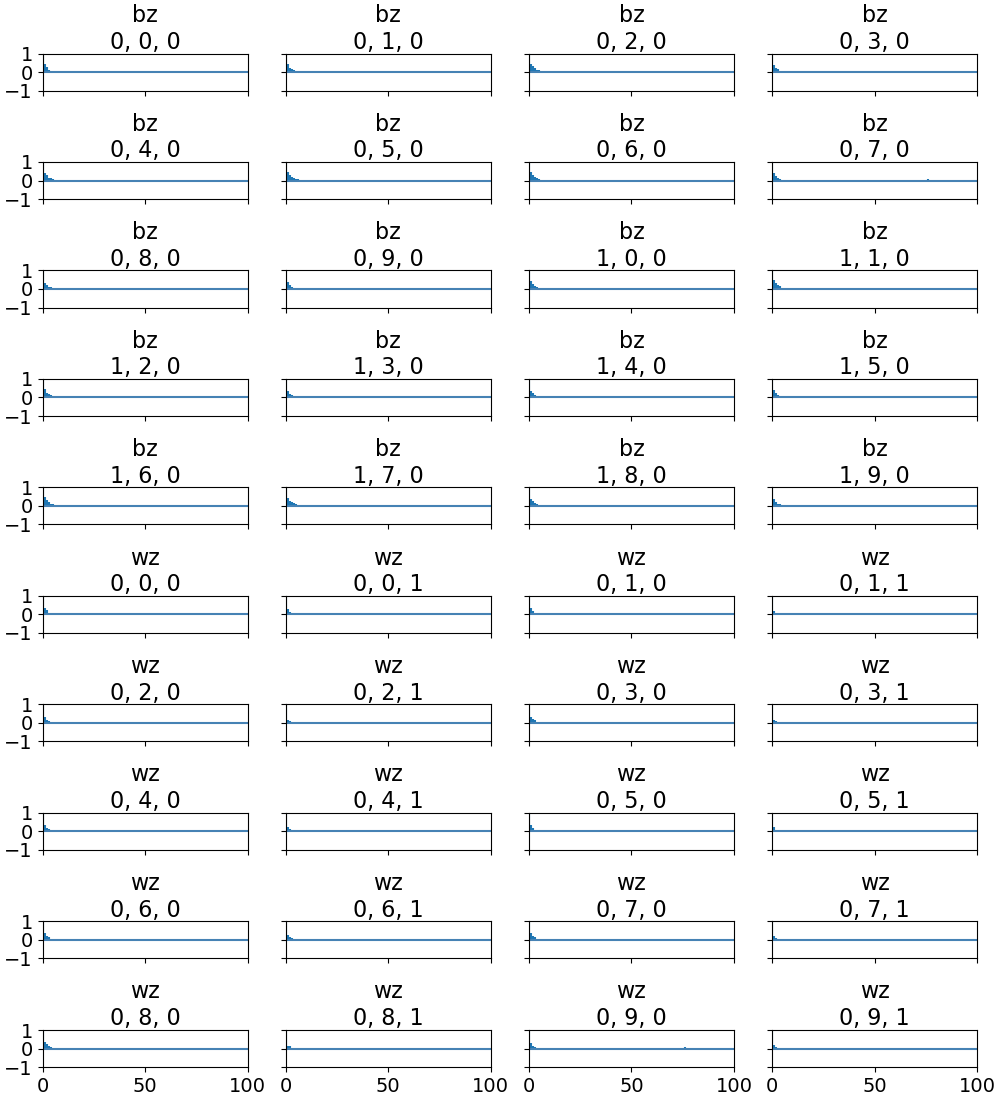

In [108]:
pm.plots.autocorrplot(trace, figsize=(10, 11), 
                      var_names=['bz', 'wz', 'by','wy']);